In [1]:
#%%capture
%pip install fft-conv-pytorch imagecorruptions psfmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!mkdir data data/blur data/gt

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/blur’: File exists
mkdir: cannot create directory ‘data/gt’: File exists


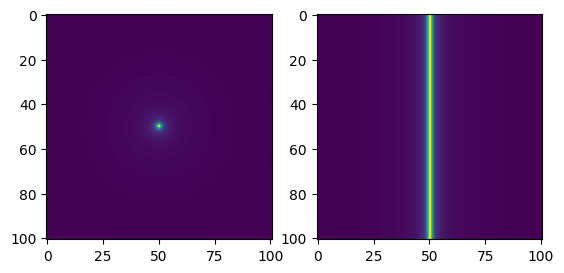

In [79]:
import torch
import torch.nn.functional as F
import numpy as np

import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# generate centered psf with a point source at `pz` microns from coverslip
nx, ny, nz = 101, 101, 101
psf = psfm.make_psf(nx, ny, dxy=0.2, dz=0., pz=0.) # dxy=0.2, dz=0.5, pz=0.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(psf[nz//2], norm=PowerNorm(gamma=0.4))
ax2.imshow(psf[:, nx//2], norm=PowerNorm(gamma=0.4))
plt.show()

k_ = psf/np.sum(psf)
k_l = psf.shape[0]

k_torch = torch.from_numpy(k_.copy()).double()
k_torch = k_torch.unsqueeze(0).unsqueeze(0)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

def create_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

def create_hollow_sphere(arr_size, center, r):
    assert r >= 3

    t = np.random.randint(0, r//2 + 1)

    a = create_sphere(arr_size, center, r)
    b = create_sphere(arr_size, center, r - t)
    return a - b

# ---------------------------------------------------------------

def place_sphere(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        r = np.random.randint(3,5)
    else:
        r = np.clip(np.random.randint(10,50), 0, c_dim_z//2-1)

    x_c = np.random.randint(r,c_dim_xy-r)
    y_c = np.random.randint(r,c_dim_xy-r)
    z_c = np.random.randint(r,c_dim_z-r)

    sphere_center = (z_c,y_c,x_c)

    h = np.random.randint(0,2)
    if h == 0:
        obj = create_sphere(canvas.shape, sphere_center, r)
    else:
        obj = create_hollow_sphere(canvas.shape, sphere_center, r)

    canvas[np.where(obj)] = np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas


# long block along z-axis
def place_z_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,5)
        y_len = np.random.randint(1,5)
        z_len = np.random.randint(1,np.min([10, c_dim_z]))
    else:
        x_len = np.random.randint(1,30)
        y_len = np.random.randint(1,30)
        z_len = np.clip(np.random.randint(1,100), 0, c_dim_z-1)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

# long block along y-axis
def place_y_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,5)
        y_len = np.random.randint(1,10)
        z_len = np.random.randint(1,5)
    else:
        x_len = np.random.randint(1,30)
        y_len = np.random.randint(1,100)
        z_len = np.random.randint(1,30)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

# long block along x-axis
def place_x_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,10)
        y_len = np.random.randint(1,5)
        z_len = np.random.randint(1,5)
    else:
        x_len = np.random.randint(1,100)
        y_len = np.random.randint(1,30)
        z_len = np.random.randint(1,30)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

#place real images of plankton
def load_plankton_images(folder_path, image_size):
    plankton_images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv.imread(image_path)
            image = cv.resize(image, image_size)  # Resize the image to the desired size
            plankton_images.append(image)
    
    return plankton_images

def place_plankton_on_canvas(canvas, plankton_images, num_plankton):
    c_dim_z, c_dim_xy = canvas.shape[0], canvas.shape[1]

    for _ in range(num_plankton):
        plankton_index = np.random.randint(0, len(plankton_images))
        plankton_image = plankton_images[plankton_index]/255# normalize image
        plankton_image = 1 - plankton_image.transpose(2, 0, 1)# invert and transpose the image so it fits the canvas structure

        _, plankton_h, plankton_w = plankton_image.shape
        plankton_d = 7 # define the respected z-thickness 
        plankton_image = np.concatenate((plankton_image, np.tile(plankton_image, (20, 1, 1))), axis=0)[:plankton_d] #create the z-dimension of the object
        x_start = np.random.randint(0, c_dim_xy - plankton_w)
        y_start = np.random.randint(0, c_dim_xy - plankton_h)
        z_start = np.random.randint(0, max(1, c_dim_z - plankton_d))  # Adjust z as needed
        print(z_start)

        obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))
        canvas[z_start:z_start + plankton_d, y_start:y_start + plankton_h, x_start:x_start + plankton_w] = plankton_image

        #canvas[np.where(obj > 0)] = 1

    return canvas

# ---------------------------------------------------------------
c_dim_xy = 512
c_dim_z = 11 # 32
# ---------------------------------------------------------------
canvas = np.zeros((c_dim_z,c_dim_xy,c_dim_xy)) #+ 0.1

image_size = (64, 64)  # Desired size for plankton images
num_plankton = 1  # Number of plankton to place

# Load plankton images from a folder
folder_path = "/home/plankton/PISCO_Software/EDOF_Sim/"
plankton_images = load_plankton_images(folder_path, image_size)

# for _ in range(300): # 300
#     canvas = place_sphere(canvas)

# for _ in range(40): # 40
#     canvas = place_x_block(canvas)
#     canvas = place_y_block(canvas)
#     canvas = place_z_block(canvas)

canvas = place_plankton_on_canvas(canvas,plankton_images,num_plankton=1)
for _ in range(100): # 200
    canvas = place_sphere(canvas, small=False)
    canvas = place_x_block(canvas, small=True)
    canvas = place_y_block(canvas, small=True)
    canvas = place_z_block(canvas, small=True)


0


In [55]:
k_l//2

50

In [77]:
from fft_conv_pytorch import fft_conv
import imgaug.augmenters as iaa


x_torch = torch.from_numpy(canvas).double()
x_torch = F.pad(
    x_torch, 
    (k_l//2,k_l//2,k_l//2,k_l//2,k_l//2,k_l//2), 
    mode='constant', 
    value=torch.mean(x_torch)
)

x_torch_1 = x_torch.unsqueeze(0).unsqueeze(0)

y_torch_1 = fft_conv(x_torch_1, k_torch)

np_blur = y_torch_1.detach().cpu().numpy()

yy = 1 - np.mean(np_blur[0,0],0)
np_blur = 1 - np.max(np_blur[0,0],0)

#rates = torch.rand((yy.shape))
#y_torch_2 = yy + torch.poisson(rates).numpy() * 0.001

#np_blur = (y_torch_2 + torch.randn(y_torch_2.shape).detach().cpu().numpy()*0.0001)

np_blur = (np_blur*255.).astype(np.uint8)
jpeg = iaa.JpegCompression(compression=10)
np_blur = jpeg(images=np_blur)

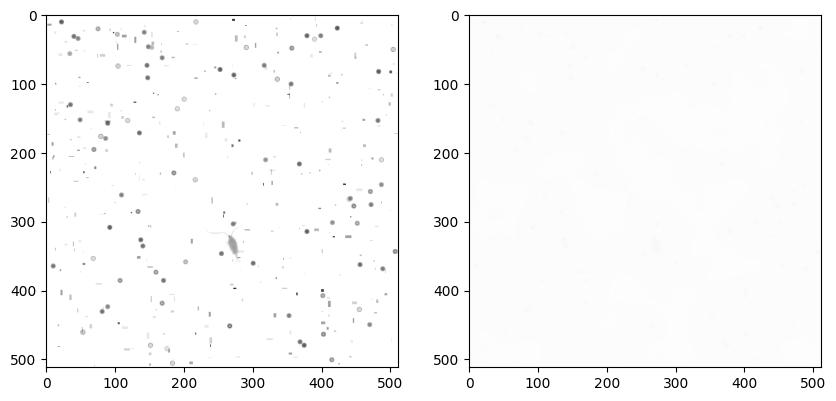

In [78]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(1-np.mean(canvas,0), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(np_blur, cmap='gray', vmin=0, vmax=255)
plt.show()

In [74]:
from PIL import Image

INDEX=16

Image.fromarray(np_blur).convert('L').save('data/blur/'+str(INDEX)+'.png')

tmp = (1 - np.mean(canvas,0))
# tmp = (tmp - np.min(tmp))/(np.max(tmp) - np.min(tmp))
Image.fromarray(tmp*255.).convert('L').save('data/gt/'+str(INDEX)+'.png')

In [ ]:
!tar czf data.tar.gz data

In [4]:
import numpy as np
import cv2 as cv


def directional_dilation(img, kernel, iterations=1):
    for _ in range(iterations):
        res = np.zeros(img.shape, dtype=np.uint8)
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                y_min = y - kernel//2
                y_min = y_min if y_min > 0 else 0
                y_max = y + kernel // 2 + 1
                y_max = y_max if y_max < img.shape[0] else img.shape[0]
                
                x_min = x - kernel//2
                x_min = x_min if x_min > 0 else 0
                x_max = x + kernel // 2 + 1
                x_max = x_max if x_max < img.shape[1] else img.shape[1]
                    
                res[y,x] = np.min(img[y_min:y_max, x_min:x_max][(y_max - y_min)//2:, (x_max - x_min)//2:])
        img = res.copy()
    return res

img = cv.imread("/home/plankton/PISCO_Software/EDOF_Sim/test.jpg", cv.IMREAD_GRAYSCALE)
    # res = directional_dilation(img, 5)

cv.imwrite("img.png", img)
cv.imwrite("res33.png", directional_dilation(img, 33))
    # cv.imshow("res33", directional_dilation(img, 31))
    # cv.imshow("res5", directional_dilation(img, 11))
    # cv.imshow("res21", directional_dilation(img, 21))
    # cv.imshow("diff", cv.absdiff(img, directional_dilation(img, 21)))
    #cv.waitKey()

True